500 500 500 34


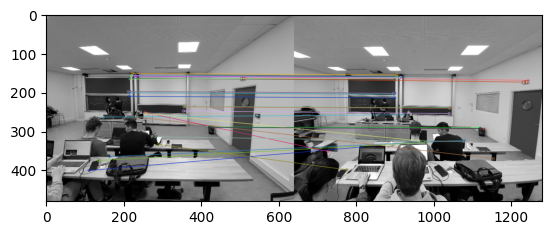

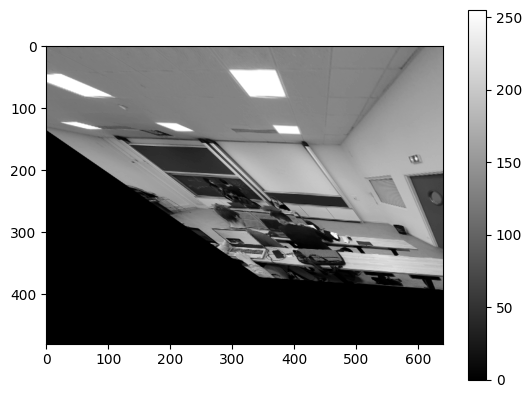

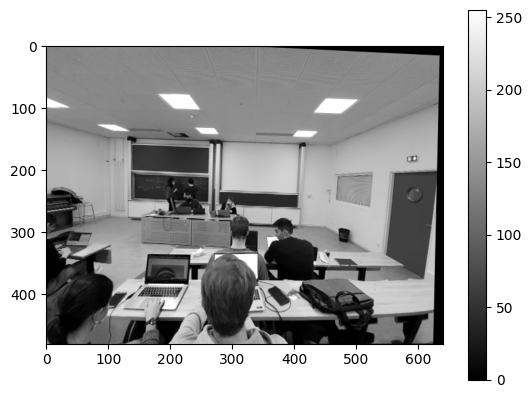

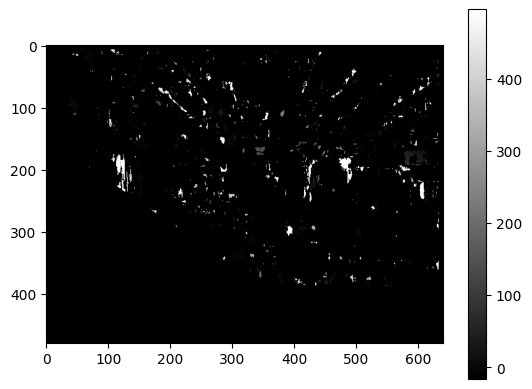

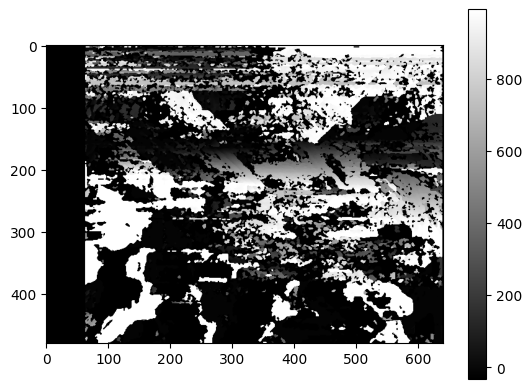

In [51]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

imgL = cv2.imread("../output/recordings/screen1.png", cv2.IMREAD_GRAYSCALE)  # left image
imgR = cv2.imread("../output/recordings/screen2.png", cv2.IMREAD_GRAYSCALE)  # right image


def get_keypoints_and_descriptors(imgL, imgR):
    """Use ORB detector and FLANN matcher to get keypoints, descritpors,
    and corresponding matches that will be good for computing
    homography.
    """
    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(imgL, None)
    kp2, des2 = orb.detectAndCompute(imgR, None)

    ############## Using FLANN matcher ##############
    # Each keypoint of the first image is matched with a number of
    # keypoints from the second image. k=2 means keep the 2 best matches
    # for each keypoint (best matches = the ones with the smallest
    # distance measurement).
    FLANN_INDEX_LSH = 6
    index_params = dict(
        algorithm=FLANN_INDEX_LSH,
        table_number=6,  # 12
        key_size=20,  # 20
        multi_probe_level=2,
    )  # 2
    #FLANN_INDEX_KDTREE = 0
    #index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)  # or pass empty dictionary
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    flann_match_pairs = flann.knnMatch(des1, des2, k=2)

    #bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    #matches = bf.match(des1, des2)
    
    # Sort them in the order of their distance.
    #flann_match_pairs = sorted(matches, key = lambda x:x.distance)

    return kp1, des1, kp2, des2, flann_match_pairs


def lowes_ratio_test(matches, ratio_threshold=0.6):
    """Filter matches using the Lowe's ratio test.

    The ratio test checks if matches are ambiguous and should be
    removed by checking that the two distances are sufficiently
    different. If they are not, then the match at that keypoint is
    ignored.

    https://stackoverflow.com/questions/51197091/how-does-the-lowes-ratio-test-work
    """
    filtered_matches = []
    for dmatch in matches:
        if len(dmatch) != 2:
            continue
        m,n = dmatch
        if m.distance < ratio_threshold * n.distance:
            filtered_matches.append(m)
    return filtered_matches


def draw_matches(imgL, imgR, kp1, des1, kp2, des2, flann_match_pairs):
    """Draw the first 8 mathces between the left and right images."""
    # https://docs.opencv.org/4.2.0/d4/d5d/group__features2d__draw.html
    # https://docs.opencv.org/2.4/modules/features2d/doc/common_interfaces_of_descriptor_matchers.html
    img = cv2.drawMatches(
        imgL,
        kp1,
        imgR,
        kp2,
        flann_match_pairs,
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    )
    cv2.imwrite("stereo_matches.png", img)
    #cv2.waitKey(0)
    plt.imshow(img)
    plt.show()


def compute_fundamental_matrix(matches, kp1, kp2, method=cv2.FM_RANSAC):
    """Use the set of good mathces to estimate the Fundamental Matrix.

    See  https://en.wikipedia.org/wiki/Eight-point_algorithm#The_normalized_eight-point_algorithm
    for more info.
    """
    pts1, pts2 = [], []
    fundamental_matrix, inliers = None, None
    for m in matches[:8]:
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)
    if pts1 and pts2:
        # You can play with the Threshold and confidence values here
        # until you get something that gives you reasonable results. I
        # used the defaults
        fundamental_matrix, inliers = cv2.findFundamentalMat(
            np.float32(pts1),
            np.float32(pts2),
            method=method,
            ransacReprojThreshold=3,
            confidence=0.9,
        )
    return fundamental_matrix, inliers, pts1, pts2


############## Find good keypoints to use ##############
kp1, des1, kp2, des2, flann_match_pairs = get_keypoints_and_descriptors(imgL, imgR)
good_matches = lowes_ratio_test(flann_match_pairs, 0.7)
print(len(kp1), len(kp2), len(flann_match_pairs), len(good_matches))

draw_matches(imgL, imgR, kp1, des1, kp2, des2, good_matches)


############## Compute Fundamental Matrix ##############
F, I, points1, points2 = compute_fundamental_matrix(good_matches, kp1, kp2)


############## Stereo rectify uncalibrated ##############
h1, w1 = imgL.shape
h2, w2 = imgR.shape
thresh = 10
_, H1, H2 = cv2.stereoRectifyUncalibrated(
    np.float32(points1), np.float32(points2), F, imgSize=(w1, h1), threshold=thresh,
)

############## Undistort (Rectify) ##############
imgL_undistorted = cv2.warpPerspective(imgL, H1, (w1, h1))
imgR_undistorted = cv2.warpPerspective(imgR, H2, (w2, h2))
cv2.imwrite("stereo_undistorted_L.png", imgL_undistorted)
cv2.imwrite("stereo_undistorted_R.png", imgR_undistorted)
plt.imshow(imgL_undistorted, "gray")
plt.colorbar()
plt.show()
plt.imshow(imgR_undistorted, "gray")
plt.colorbar()
plt.show()
############## Calculate Disparity (Depth Map) ##############

# Using StereoBM
stereo = cv2.StereoBM_create(numDisparities=32, blockSize=15)
disparity_BM = stereo.compute(imgL_undistorted, imgR_undistorted)
plt.imshow(disparity_BM, "gray")
plt.colorbar()
plt.show()

# Using StereoSGBM
# Set disparity parameters. Note: disparity range is tuned according to
#  specific parameters obtained through trial and error.
win_size = 5
min_disp = -1
max_disp = 63
num_disp = max_disp - min_disp  # Needs to be divisible by 16
stereo = cv2.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=5,
    uniquenessRatio=5,
    speckleWindowSize=5,
    speckleRange=5,
    disp12MaxDiff=1,
    P1=8 * 3 * win_size ** 2,
    P2=32 * 3 * win_size ** 2,
)
disparity_SGBM = stereo.compute(imgL_undistorted, imgR_undistorted)
plt.imshow(disparity_SGBM, "gray")
plt.colorbar()
plt.show()



In [52]:
cv2.imwrite("stereo_disparity_bm.png", disparity_BM)
cv2.imwrite("stereo_disparity_sgbm.png", disparity_SGBM)


True